In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid', {'legend.frameon':True})

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

from IPython.display import clear_output

# Loads

In [2]:
data = {}
for ville in ['paris', 'lyon', 'toulouse', 'nantes', 'bordeaux']:
    df = pd.read_csv('csv/%s.csv'%ville)
    X_train, X_test, y_train, y_test = train_test_split(df, df['salary_mean'], test_size=.3, random_state=0)
    data[ville] = {'X_train':X_train, 'X_test':X_test, 'y_train':y_train, 'y_test':y_test}

# Global

## metrics

In [3]:
REGR_METRICS = [
    ('r2', lambda x, y, z: r2_score(x, y)),
    ('ar2', lambda x, y, z: 1-(1-r2_score(x, y))*((len(x)-1)/(len(x)-z-1))),
    ('mae', lambda x, y, z: mean_absolute_error(x, y) / y.mean()),
    ('mse', lambda x, y, z: mean_squared_error(x, y) / (y.mean()**2)),
    ('rmse', lambda x, y, z: mean_squared_error(x, y, squared=False) / y.mean())
]

In [4]:
def get_metrics(y_test, y_pred, n_features):
    metrics = []
    for metric in REGR_METRICS:
        metrics.append(metric[1](y_test, y_pred, n_features))
    return metrics

## params

In [5]:
PARAMS =[
    {'n_estimators':range(50, 1000, 50), 'learning_rate':[.005, .001, .01, .05, .1]},
    {'max_depth':list(range(2,36,2)) + [None], 'min_samples_split':range(2,24,2)},
#     {'min_samples_leaf':[1, .00001, .00005, .0001, .005, .001, .01, .05, .1, .5, .75]},
#     {'max_features':['auto', 'sqrt', 'log2', None]},
    {'subsample':[.4, .45, .5, .55, .6, .65, .7, .75, .8, .85, .9, .95, 1.0]},
    {'loss':['ls', 'lad', 'huber', 'quantile'], 'alpha': [0.0, .1, .15, .2, .25, .3, .35, .4, .45, .5, .55, .6, .65, .7, .75, .8, .85, .9, .95, 1.0]},
    {'min_impurity_decrease':[0.0, .1, .2, .3, .4, .5]},
]

## multi search

In [6]:
def multi_search(params, X_train, X_test, y_train, y_test, features, msg=''):
    full_params = {'random_state':0}
    metrics = []
    i = 0
    print('{}/{} - {:.2f} - {}'.format(i, len(params), i / len(params) * 100, msg))
    for p in params:
        search = GridSearchCV(GradientBoostingRegressor(**full_params), p, n_jobs=4, cv=5, verbose=1).fit(X_train[features], y_train)
        full_params.update(search.best_params_)
        y_pred = search.best_estimator_.predict(X_test[features])
        metrics.append(get_metrics(y_test, y_pred, len(features)))
        i+=1
        clear_output(wait=True)
        print('{}/{} - {:.2f} - {}'.format(i, len(params), i / len(params) * 100, msg))
        print(search.best_params_)
        print(search.best_estimator_.get_params())
    return full_params, metrics

## n_row

In [7]:
def n_row_search(params, X_train, X_test, y_train, y_test, features, row_step=10, msg=''):
    metrics = []
    row_count = len(y_train)
    search = np.empty((int(np.ceil(row_count/row_step)), len(REGR_METRICS)))
    i = 0
    print('{}/{} - {:.2f} - {}'.format(i, row_count, i / row_count * 100, msg))
    while i < row_count:
        i = min(i + row_step, row_count)
        model = GradientBoostingRegressor(**params).fit(X_train[features][:i], y_train[:i])
        y_pred = model.predict(X_test[features])
        metrics.append(get_metrics(y_test, y_pred, len(features)))
        clear_output(wait=True)
        print('{}/{} - {:.2f} - {}'.format(i, row_count, i / row_count * 100, msg))
    return (metrics, model.feature_importances_)

## plot search

In [8]:
def plot_searchs(params, grid_metrics, n_row_metrics, feature_importances, features):
    print("\nModel Report\n")
    print('Features : %s\n'%features)
    print('Params : %s\n'%params)
    print('R2 : %s'%np.max(grid_metrics[:,0]))
    print('AR2 : %s'%np.max(grid_metrics[:,1]))
    print('MAE/MEAN : %s'%np.min(grid_metrics[:,2]))
    print('MSE/MEAN² : %s'%np.min(grid_metrics[:,3]))
    print('RMSE/MEAN : %s'%np.min(grid_metrics[:,4]))
    
    fig, axs = plt.subplots(1,2, figsize=(20,5))
    fig.suptitle('Perfomance of the model')
    axs[0].plot(np.arange(grid_metrics.shape[0]), grid_metrics[:,0])
    axs[0].set_title('GridSearch R² evolution')
    axs[1].plot(np.arange(n_row_metrics.shape[0]), n_row_metrics[:,0])
    axs[1].set_title('n_row R² evolution')
    plt.show()
    pd.Series(feature_importances, features).sort_values(ascending=False).plot(figsize=(20,5), kind='bar', title='Feature Importances')
    plt.show()
    

## plot model

In [9]:
def plot_pred(params, X_train, X_test, y_train, y_test, features):
    y_pred = GradientBoostingRegressor(**params).fit(X_train[features], y_train).predict(X_test[features])
    res = pd.DataFrame([(y_test.to_numpy()[i], y_pred[i]) for i in range(len(y_test))], columns=['true', 'pred']).sort_values('true')
    res['pred-mae'] = res['pred'] - mean_absolute_error(y_test, y_pred)
    res['pred+mae'] = res['pred'] + mean_absolute_error(y_test, y_pred)
#     print(res)
    plt.plot(np.arange(len(res)), res['true'])
    plt.plot(np.arange(len(res)), res['pred'])    

# Without query

In [10]:
features = list(df.columns[1:14])
for key, value in data.items():
    clear_output(wait=True)
    params, grid_metrics = multi_search(PARAMS, value['X_train'], value['X_test'], value['y_train'], value['y_test'], features, msg=key)
    n_row_metrics, feature_importances = n_row_search(params, value['X_train'], value['X_test'], value['y_train'], value['y_test'], features, msg=key)
    data[key].update({'params':params, 'grid_metrics':grid_metrics, 'n_row_metrics':n_row_metrics, 'feature_importances':feature_importances})

70/70 - 100.00 - bordeaux


paris


Model Report

Features : ['rating_mean', 'rating_count', 'contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission', 'contract_apprentissage', 'mode_an']

Params : {'random_state': 0, 'learning_rate': 0.01, 'n_estimators': 200, 'max_depth': 2, 'min_samples_split': 2, 'subsample': 1.0, 'alpha': 0.9, 'loss': 'huber', 'min_impurity_decrease': 0.0}

R2 : 0.7435696917907839
AR2 : 0.7202578455899461
MAE/MEAN : 0.18115908851508492
MSE/MEAN² : 0.06086889811780671
RMSE/MEAN : 0.24671622994405276


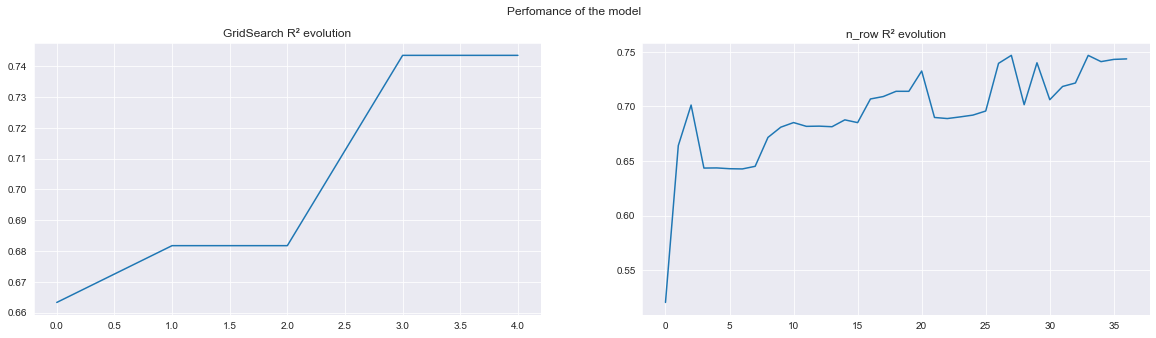

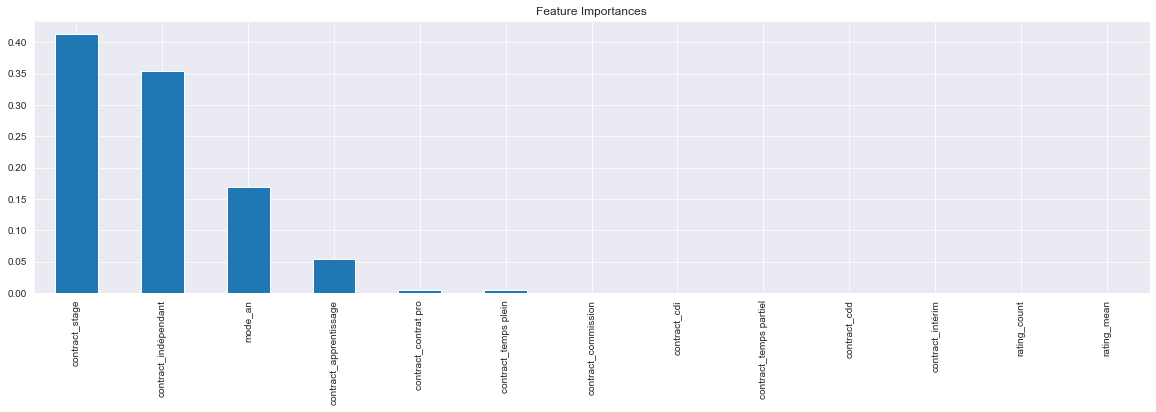

lyon


Model Report

Features : ['rating_mean', 'rating_count', 'contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission', 'contract_apprentissage', 'mode_an']

Params : {'random_state': 0, 'learning_rate': 0.005, 'n_estimators': 850, 'max_depth': 4, 'min_samples_split': 8, 'subsample': 1.0, 'alpha': 0.1, 'loss': 'ls', 'min_impurity_decrease': 0.0}

R2 : 0.720859974084492
AR2 : 0.6141299641756213
MAE/MEAN : 0.14875888677502833
MSE/MEAN² : 0.054497050635656644
RMSE/MEAN : 0.2334460336687189


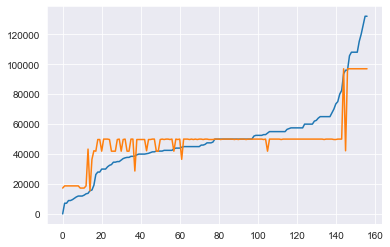

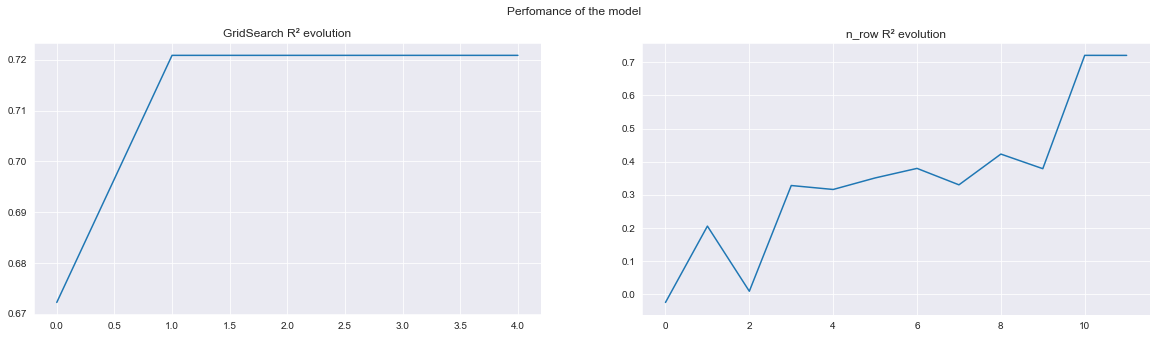

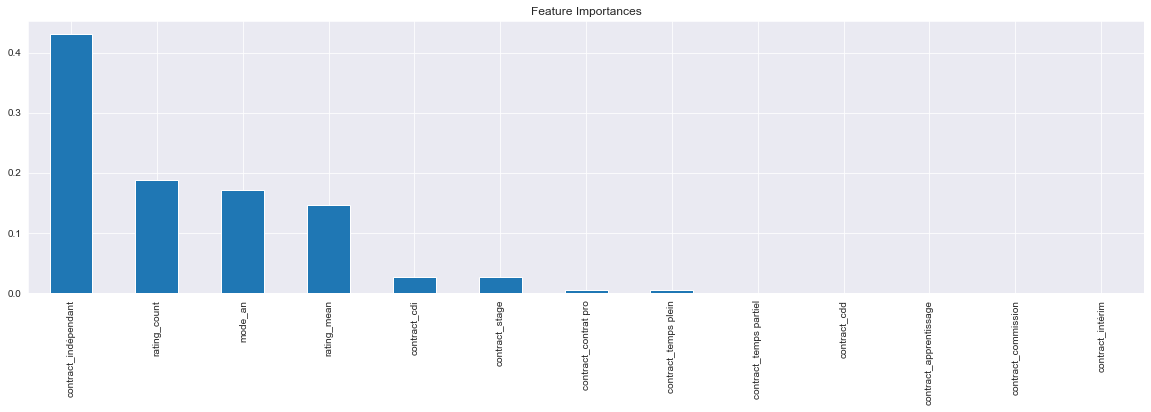

toulouse


Model Report

Features : ['rating_mean', 'rating_count', 'contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission', 'contract_apprentissage', 'mode_an']

Params : {'random_state': 0, 'learning_rate': 0.005, 'n_estimators': 600, 'max_depth': 6, 'min_samples_split': 22, 'subsample': 1.0, 'alpha': 0.3, 'loss': 'quantile', 'min_impurity_decrease': 0.1}

R2 : 0.33323301702236674
AR2 : -0.5335640608485563
MAE/MEAN : 0.17155691451237795
MSE/MEAN² : 0.07173535879902711
RMSE/MEAN : 0.26783457356925955


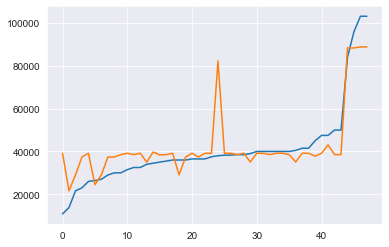

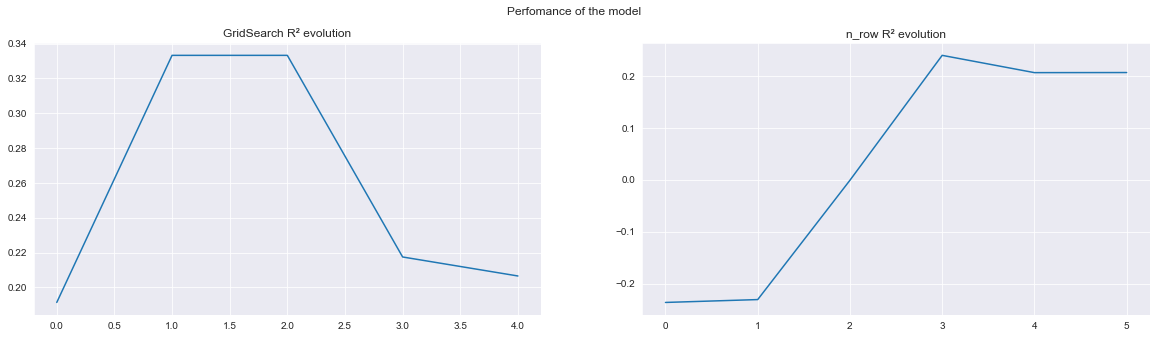

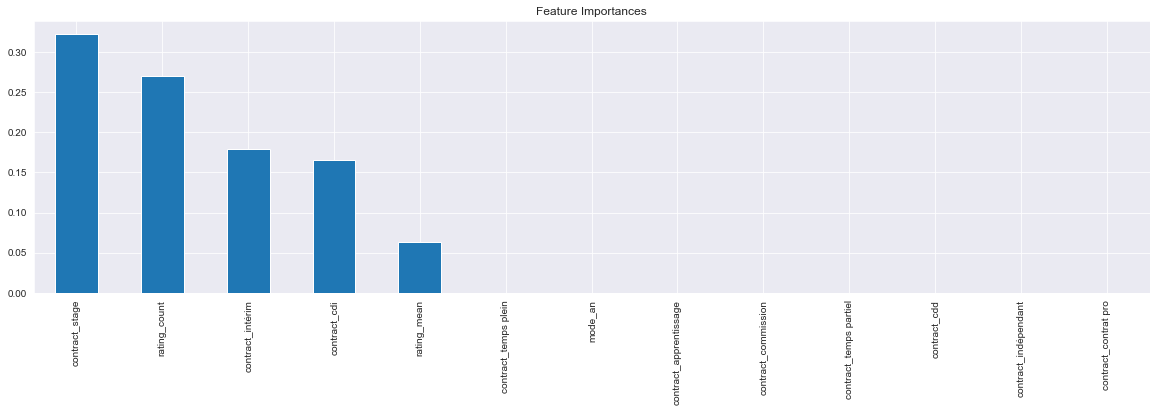

nantes


Model Report

Features : ['rating_mean', 'rating_count', 'contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission', 'contract_apprentissage', 'mode_an']

Params : {'random_state': 0, 'learning_rate': 0.001, 'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 2, 'subsample': 0.45, 'alpha': 0.55, 'loss': 'quantile', 'min_impurity_decrease': 0.0}

R2 : 0.035310415308515974
AR2 : -0.2433776869356905
MAE/MEAN : 0.21743294321634024
MSE/MEAN² : 0.10157088142174608
RMSE/MEAN : 0.31870186918458143


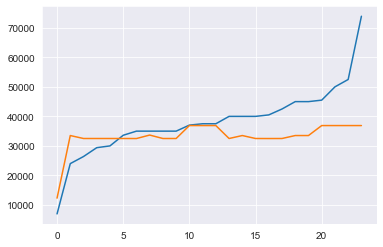

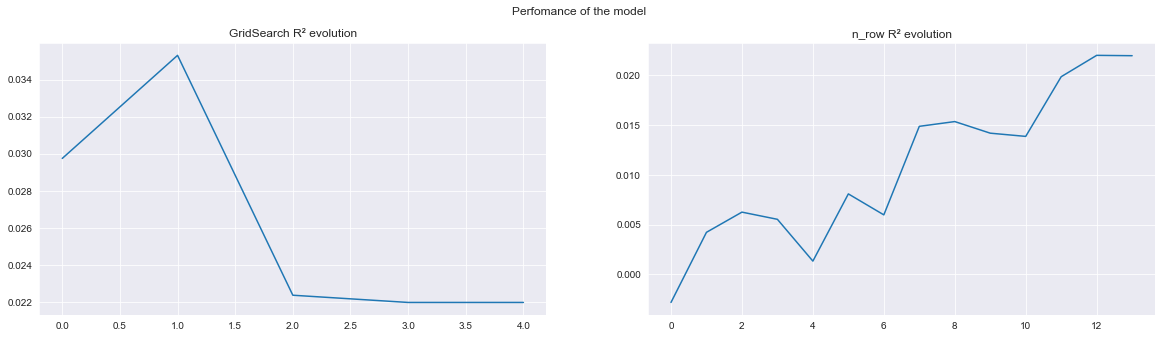

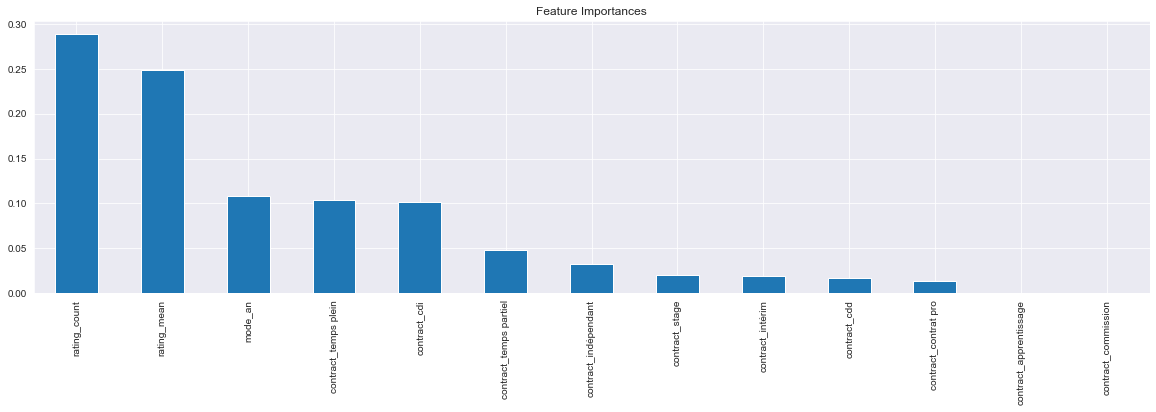

bordeaux


Model Report

Features : ['rating_mean', 'rating_count', 'contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission', 'contract_apprentissage', 'mode_an']

Params : {'random_state': 0, 'learning_rate': 0.05, 'n_estimators': 950, 'max_depth': 4, 'min_samples_split': 2, 'subsample': 1.0, 'alpha': 0.95, 'loss': 'huber', 'min_impurity_decrease': 0.5}

R2 : 0.5486971480249481
AR2 : 0.20358320239696726
MAE/MEAN : 0.14599265676676976
MSE/MEAN² : 0.03657490346690338
RMSE/MEAN : 0.19124566260938675


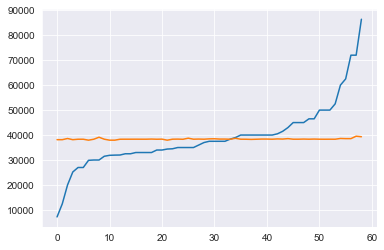

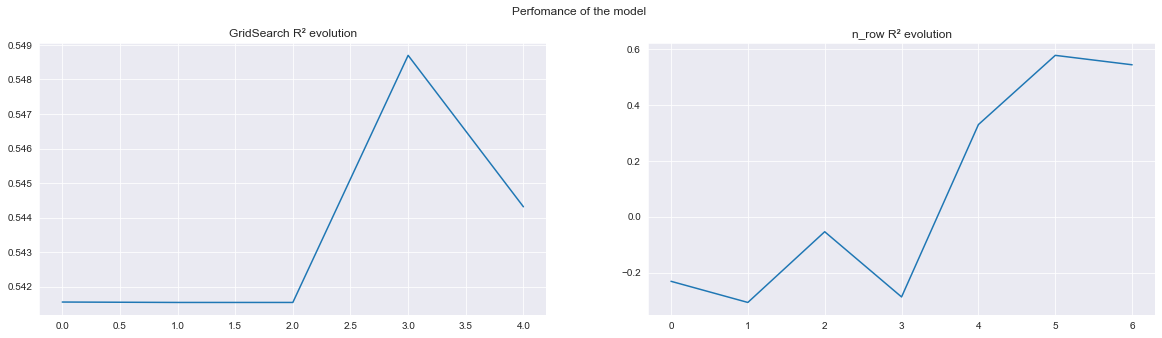

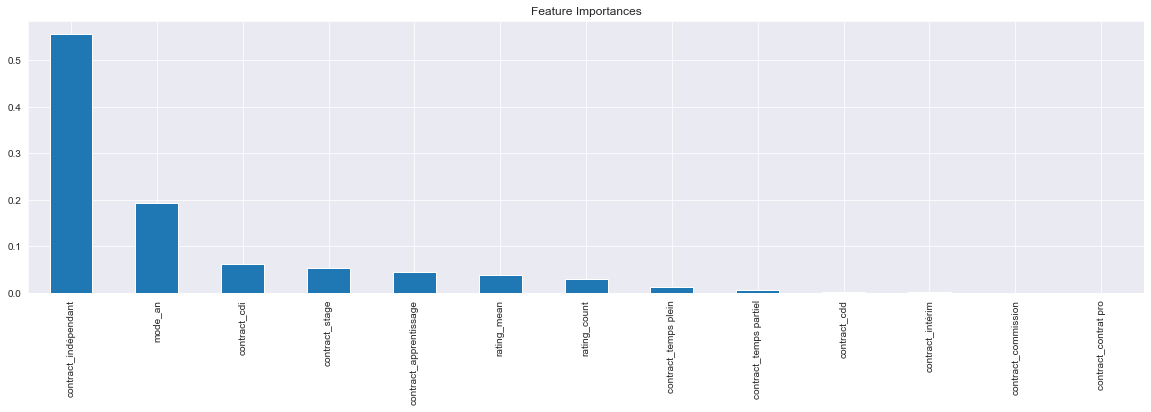

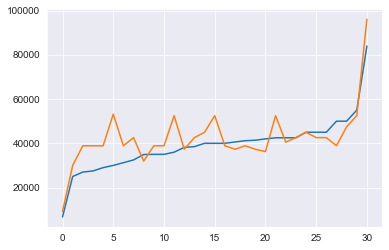

In [11]:
features = list(df.columns[1:14])
for key, value in data.items():
    print('{}\n'.format(key))
    plot_searchs(value['params'], np.array(value['grid_metrics']), np.array(value['n_row_metrics']), value['feature_importances'], features)
    plot_pred(value['params'], value['X_train'], value['X_test'], value['y_train'], value['y_test'], features)

# With query

In [12]:
features = list(df.columns[1:14]) + list(df.columns[18:])
for key, value in data.items():
    clear_output(wait=True)
    params, grid_metrics = multi_search(PARAMS, value['X_train'], value['X_test'], value['y_train'], value['y_test'], features, msg=key)
    n_row_metrics, feature_importances = n_row_search(params, value['X_train'], value['X_test'], value['y_train'], value['y_test'], features, msg=key)
    data[key].update({'params':params, 'grid_metrics':grid_metrics, 'n_row_metrics':n_row_metrics, 'feature_importances':feature_importances})

70/70 - 100.00 - bordeaux


paris


Model Report

Features : ['rating_mean', 'rating_count', 'contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission', 'contract_apprentissage', 'mode_an', 'query_data+scientist', 'query_business+intelligence', 'query_data+analyst', 'query_developpeur']

Params : {'random_state': 0, 'learning_rate': 0.005, 'n_estimators': 450, 'max_depth': 4, 'min_samples_split': 20, 'subsample': 0.95, 'alpha': 0.75, 'loss': 'huber', 'min_impurity_decrease': 0.1}

R2 : 0.7932086784492638
AR2 : 0.767917653511404
MAE/MEAN : 0.15918201544978322
MSE/MEAN² : 0.050444252644195844
RMSE/MEAN : 0.2245979800536858


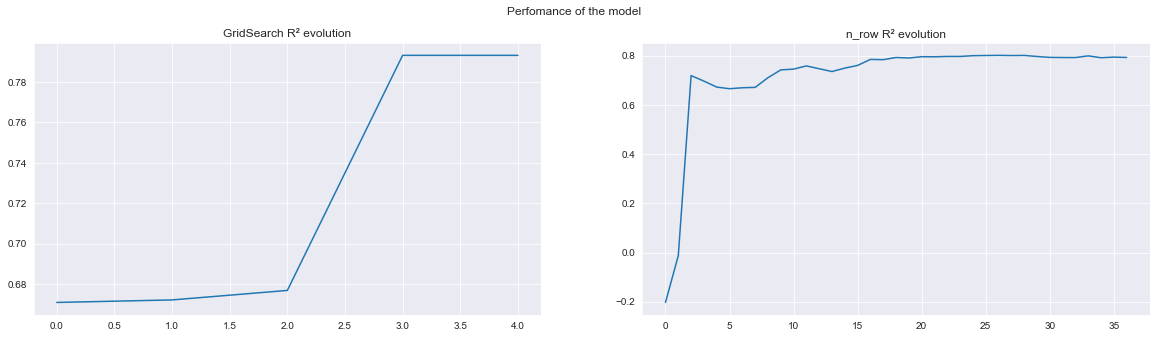

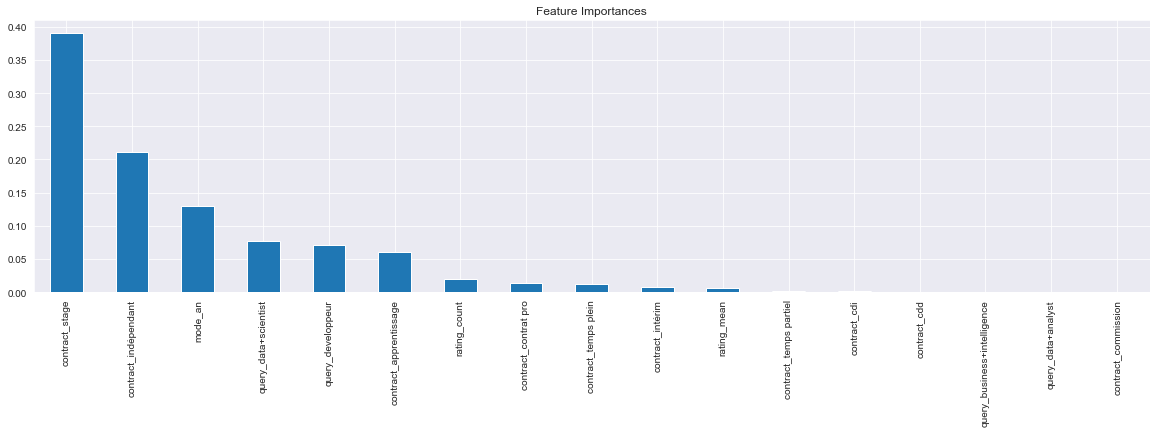

lyon


Model Report

Features : ['rating_mean', 'rating_count', 'contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission', 'contract_apprentissage', 'mode_an', 'query_data+scientist', 'query_business+intelligence', 'query_data+analyst', 'query_developpeur']

Params : {'random_state': 0, 'learning_rate': 0.01, 'n_estimators': 450, 'max_depth': 4, 'min_samples_split': 8, 'subsample': 1.0, 'alpha': 0.1, 'loss': 'ls', 'min_impurity_decrease': 0.0}

R2 : 0.7235929666161021
AR2 : 0.5669623143652266
MAE/MEAN : 0.1460024777128592
MSE/MEAN² : 0.05544150134188779
RMSE/MEAN : 0.2354601905670846


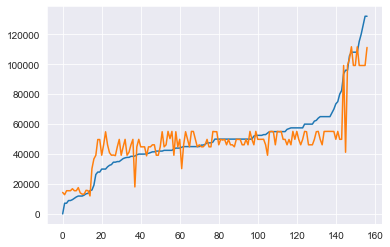

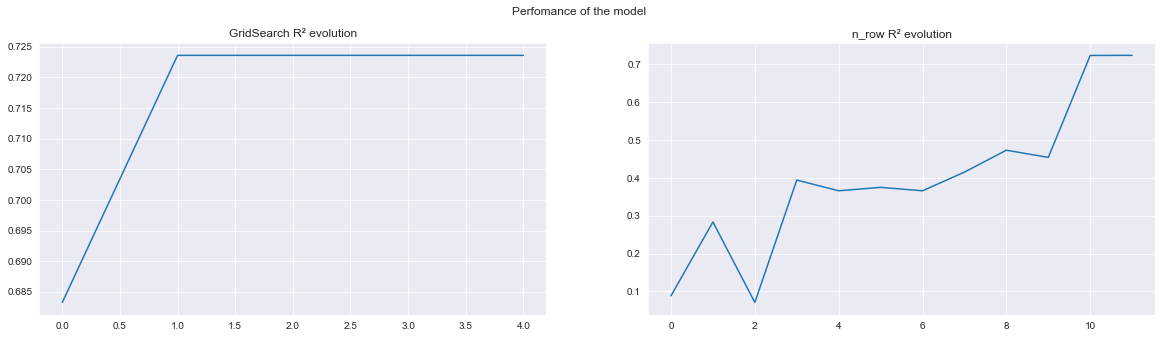

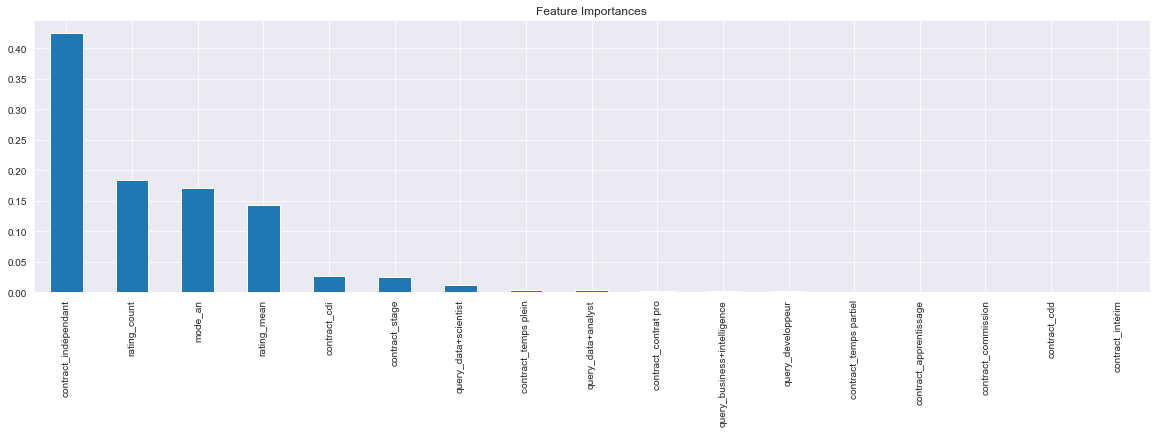

toulouse


Model Report

Features : ['rating_mean', 'rating_count', 'contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission', 'contract_apprentissage', 'mode_an', 'query_data+scientist', 'query_business+intelligence', 'query_data+analyst', 'query_developpeur']

Params : {'random_state': 0, 'learning_rate': 0.001, 'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 4, 'subsample': 0.75, 'alpha': 0.95, 'loss': 'huber', 'min_impurity_decrease': 0.0}

R2 : -0.014837515646744182
AR2 : -2.8902104766458527
MAE/MEAN : 0.22277861430232657
MSE/MEAN² : 0.11032082252779338
RMSE/MEAN : 0.3321457850519759


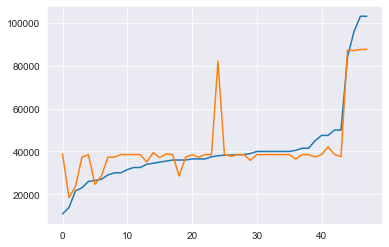

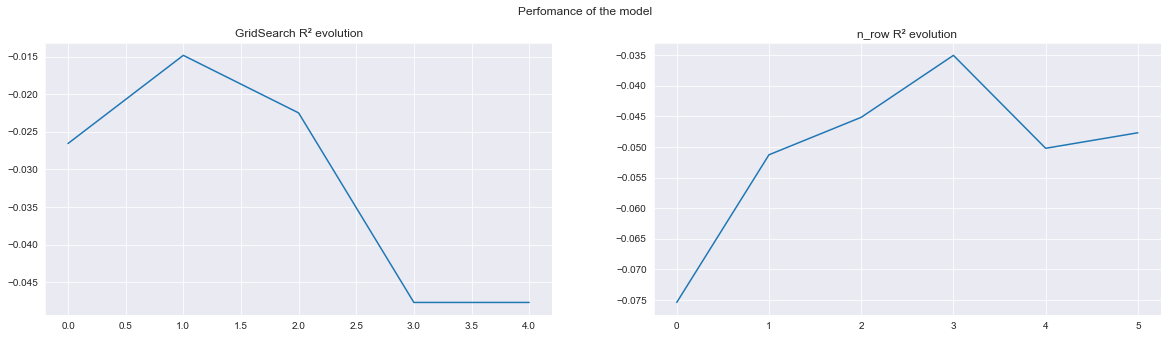

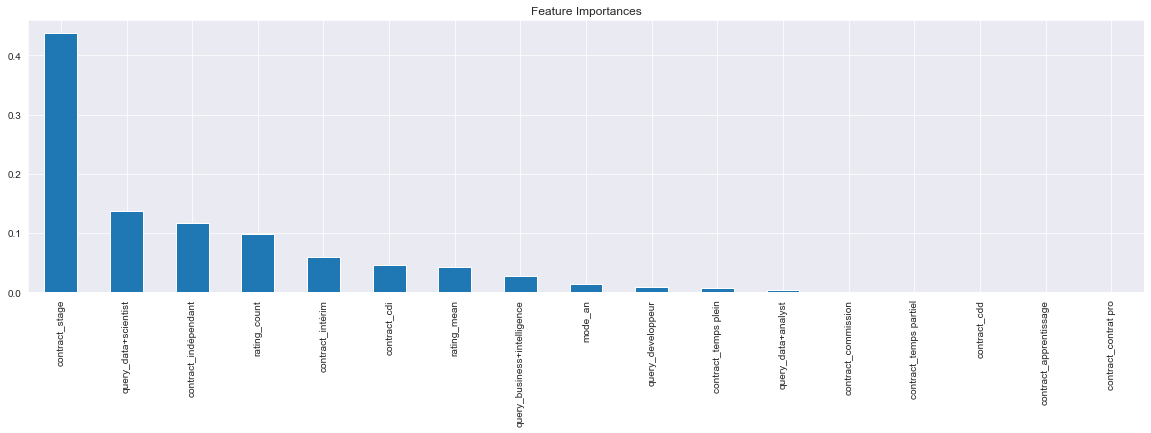

nantes


Model Report

Features : ['rating_mean', 'rating_count', 'contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission', 'contract_apprentissage', 'mode_an', 'query_data+scientist', 'query_business+intelligence', 'query_data+analyst', 'query_developpeur']

Params : {'random_state': 0, 'learning_rate': 0.001, 'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 2, 'subsample': 1.0, 'alpha': 0.55, 'loss': 'quantile', 'min_impurity_decrease': 0.0}

R2 : 0.03340644341247889
AR2 : -0.3673762507823468
MAE/MEAN : 0.2176837025558243
MSE/MEAN² : 0.10187249276645748
RMSE/MEAN : 0.3191747057121812


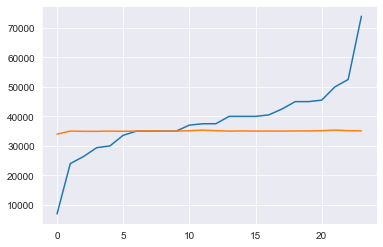

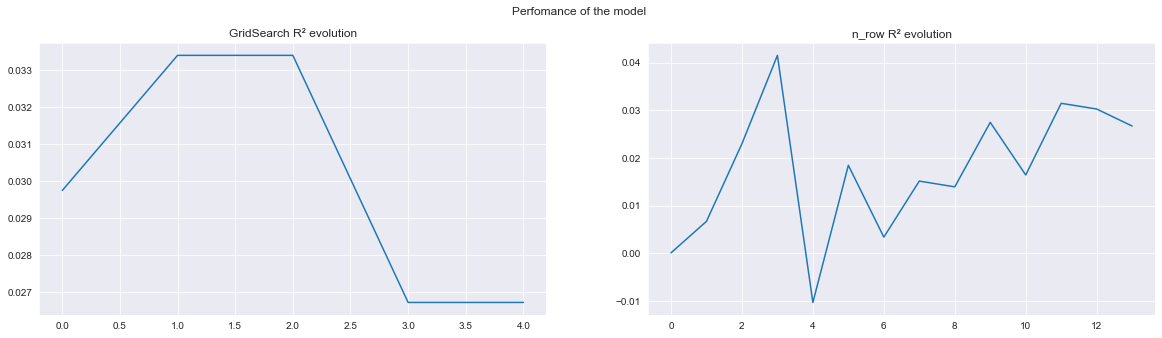

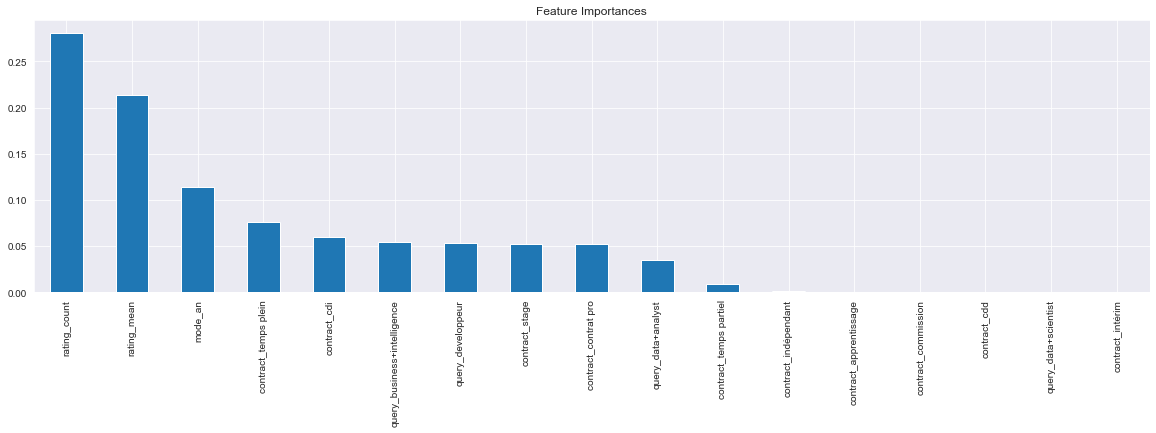

bordeaux


Model Report

Features : ['rating_mean', 'rating_count', 'contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission', 'contract_apprentissage', 'mode_an', 'query_data+scientist', 'query_business+intelligence', 'query_data+analyst', 'query_developpeur']

Params : {'random_state': 0, 'learning_rate': 0.01, 'n_estimators': 950, 'max_depth': 6, 'min_samples_split': 22, 'subsample': 1.0, 'alpha': 0.1, 'loss': 'ls', 'min_impurity_decrease': 0.0}

R2 : 0.5465660535127407
AR2 : -0.046386030355213714
MAE/MEAN : 0.14958710045934637
MSE/MEAN² : 0.03746455834857261
RMSE/MEAN : 0.1935576357278953


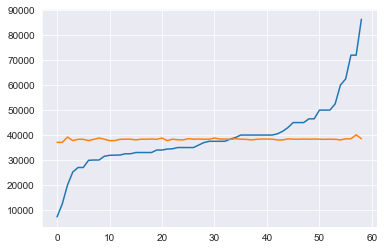

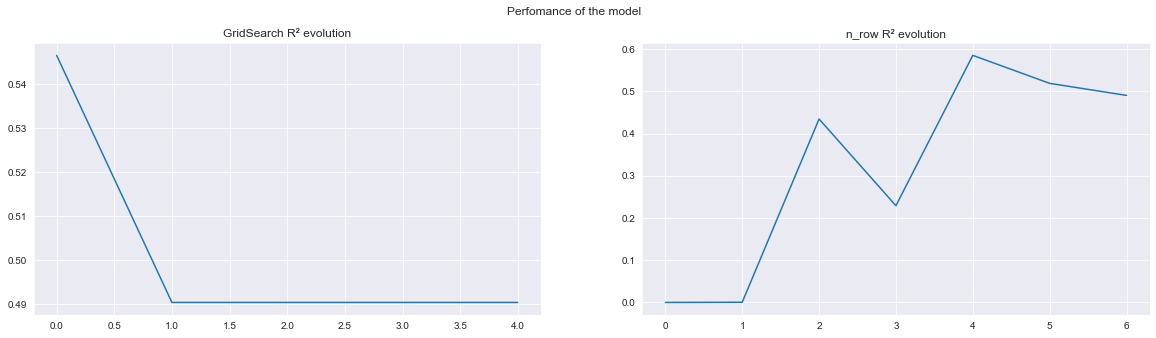

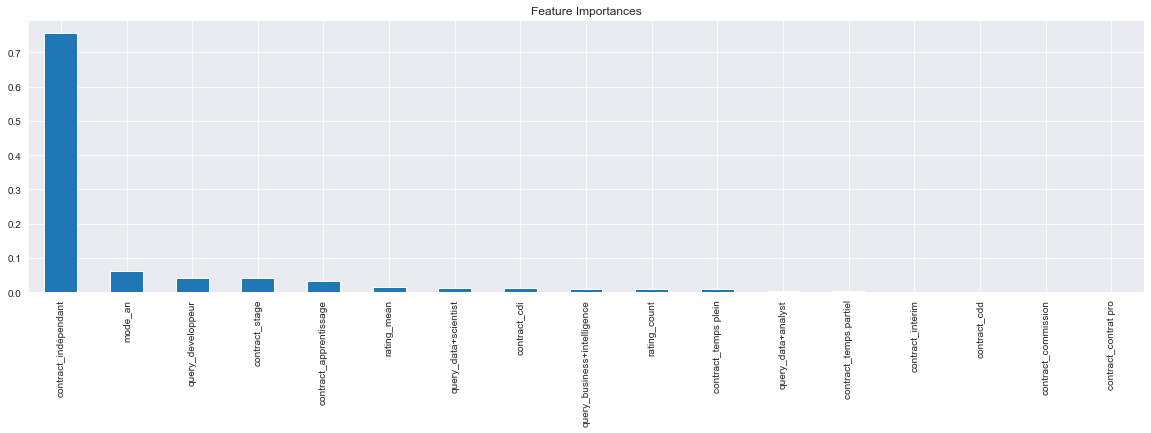

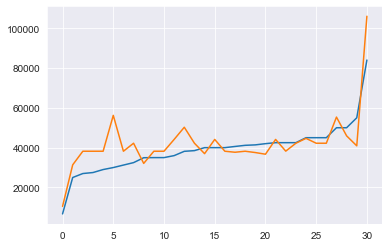

In [13]:
features = list(df.columns[1:14]) + list(df.columns[18:])
for key, value in data.items():
    print('{}\n'.format(key))
    plot_searchs(value['params'], np.array(value['grid_metrics']), np.array(value['n_row_metrics']), value['feature_importances'], features)
    plot_pred(value['params'], value['X_train'], value['X_test'], value['y_train'], value['y_test'], features)

# Paris work

In [16]:
df = pd.read_csv('csv/paris.csv')
df = df[df['salary_mean']>1000]
df.info()
X_train, X_test, y_train, y_test = train_test_split(df, df['salary_mean'], test_size=.3, random_state=0)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 521 entries, 0 to 522
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   salary_mean                  521 non-null    float64
 1   rating_mean                  521 non-null    float64
 2   rating_count                 521 non-null    int64  
 3   contract_contrat pro         521 non-null    int64  
 4   contract_intérim             521 non-null    int64  
 5   contract_temps plein         521 non-null    int64  
 6   contract_indépendant         521 non-null    int64  
 7   contract_cdd                 521 non-null    int64  
 8   contract_temps partiel       521 non-null    int64  
 9   contract_cdi                 521 non-null    int64  
 10  contract_stage               521 non-null    int64  
 11  contract_commission          521 non-null    int64  
 12  contract_apprentissage       521 non-null    int64  
 13  mode_an             

## Without query

In [18]:
features = list(df.columns[1:14])

params, grid_metrics = multi_search(PARAMS, X_train, X_test, y_train, y_test, features, msg='paris2')
n_row_metrics, feature_importances = n_row_search(params, X_train, X_test, y_train, y_test, features, msg='paris2')

364/364 - 100.00 - paris2



Model Report

Features : ['rating_mean', 'rating_count', 'contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission', 'contract_apprentissage', 'mode_an']

Params : {'random_state': 0, 'learning_rate': 0.05, 'n_estimators': 100, 'max_depth': 2, 'min_samples_split': 2, 'subsample': 0.95, 'alpha': 0.8, 'loss': 'huber', 'min_impurity_decrease': 0.1}

R2 : 0.5705535677646194
AR2 : 0.5315129830159484
MAE/MEAN : 0.20802397896542196
MSE/MEAN² : 0.09758648565847523
RMSE/MEAN : 0.31238835711094487


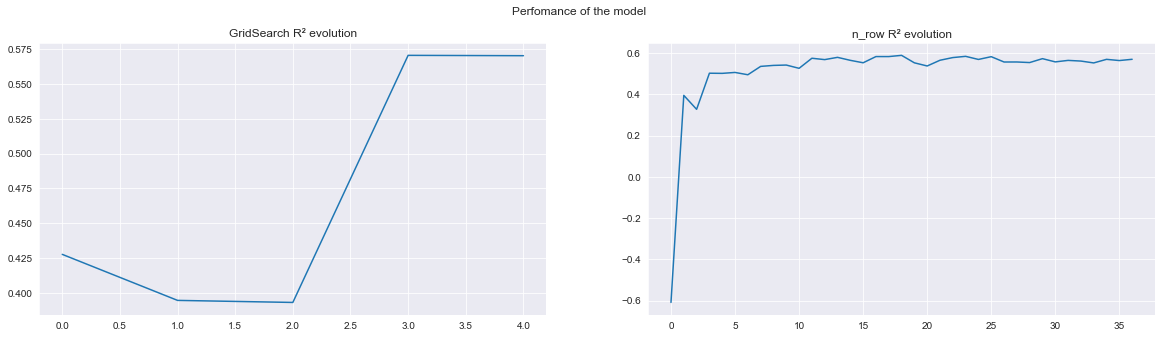

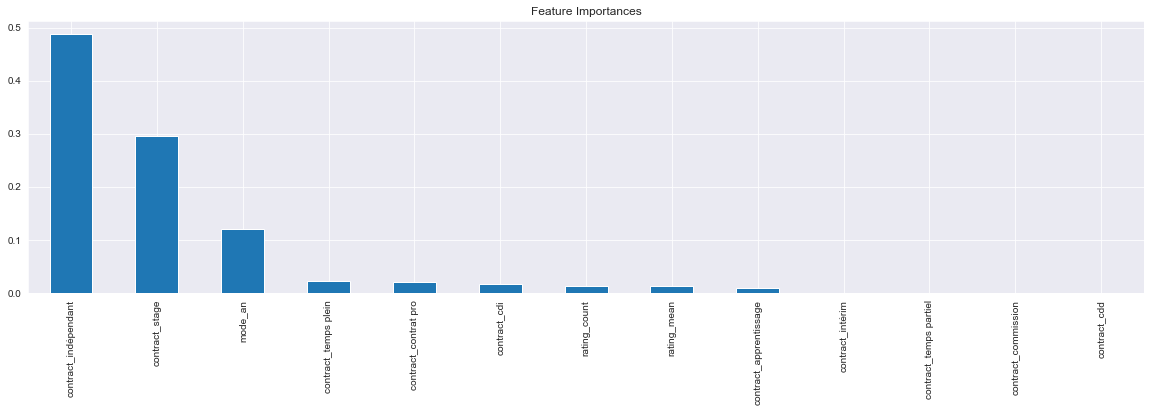

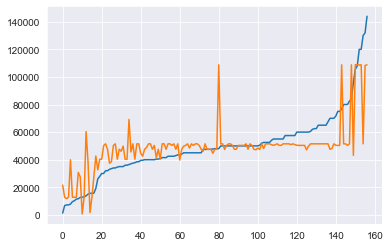

In [19]:
features = list(df.columns[1:14])

plot_searchs(params, np.array(grid_metrics), np.array(n_row_metrics), feature_importances, features)
plot_pred(params, X_train, X_test, y_train, y_test, features)

## With query

In [20]:
features = list(df.columns[1:14]) + list(df.columns[18:])

params, grid_metrics = multi_search(PARAMS, X_train, X_test, y_train, y_test, features, msg=key)
n_row_metrics, feature_importances = n_row_search(params, X_train, X_test, y_train, y_test, features, msg='paris2')

364/364 - 100.00 - paris2



Model Report

Features : ['rating_mean', 'rating_count', 'contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission', 'contract_apprentissage', 'mode_an', 'query_data+scientist', 'query_business+intelligence', 'query_data+analyst', 'query_developpeur']

Params : {'random_state': 0, 'learning_rate': 0.005, 'n_estimators': 850, 'max_depth': 12, 'min_samples_split': 22, 'subsample': 1.0, 'alpha': 0.1, 'loss': 'ls', 'min_impurity_decrease': 0.0}

R2 : 0.4751671708181555
AR2 : 0.41097898307649117
MAE/MEAN : 0.2074126056837297
MSE/MEAN² : 0.10981207812037354
RMSE/MEAN : 0.3313790550417656


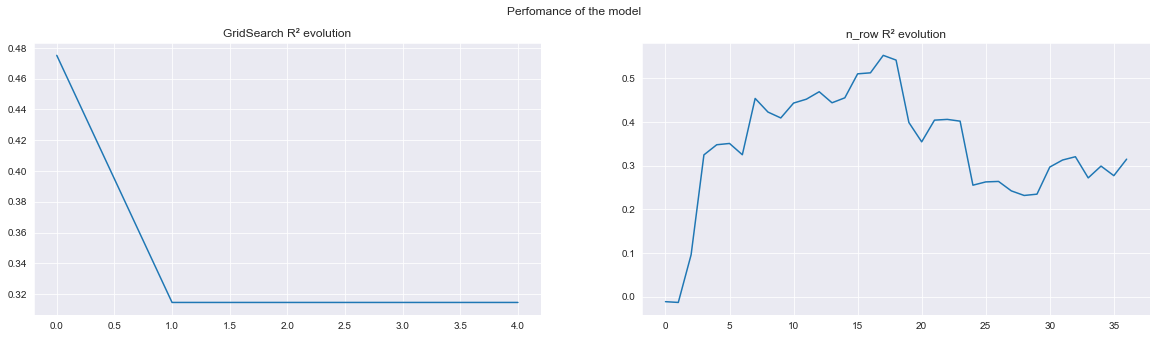

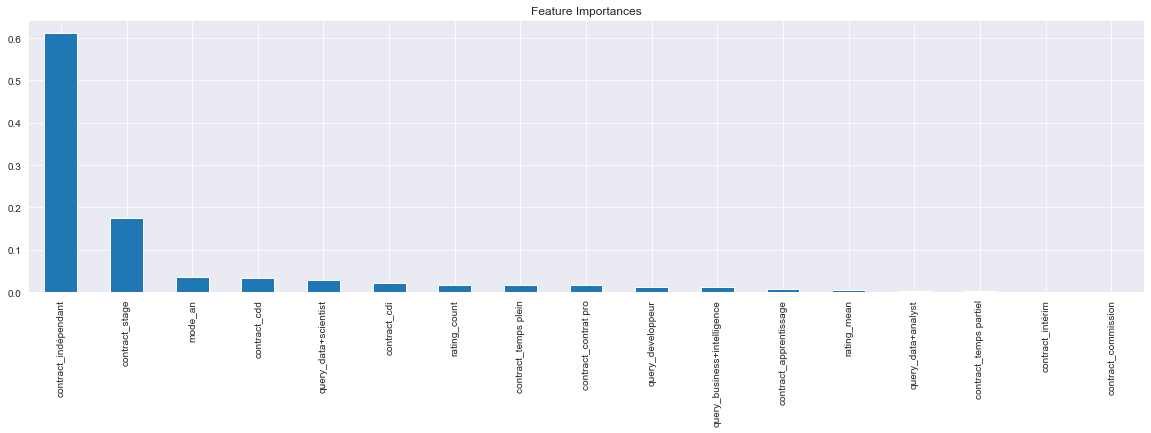

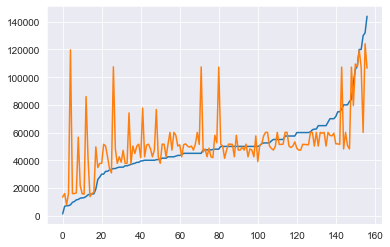

In [21]:
features = list(df.columns[1:14]) + list(df.columns[18:])

plot_searchs(params, np.array(grid_metrics), np.array(n_row_metrics), feature_importances, features)
plot_pred(params, X_train, X_test, y_train, y_test, features)

## Without ratings

In [22]:
features = list(df.columns[3:14]) + list(df.columns[18:])

params, grid_metrics = multi_search(PARAMS, X_train, X_test, y_train, y_test, features, msg='paris2')
n_row_metrics, feature_importances = n_row_search(params, X_train, X_test, y_train, y_test, features, msg='paris2')

364/364 - 100.00 - paris2



Model Report

Features : ['contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission', 'contract_apprentissage', 'mode_an', 'query_data+scientist', 'query_business+intelligence', 'query_data+analyst', 'query_developpeur']

Params : {'random_state': 0, 'learning_rate': 0.005, 'n_estimators': 850, 'max_depth': 10, 'min_samples_split': 22, 'subsample': 1.0, 'alpha': 0.1, 'loss': 'ls', 'min_impurity_decrease': 0.0}

R2 : 0.483614089204095
AR2 : 0.4286794178428285
MAE/MEAN : 0.2082205197974505
MSE/MEAN² : 0.10882345053414126
RMSE/MEAN : 0.32988399557138454


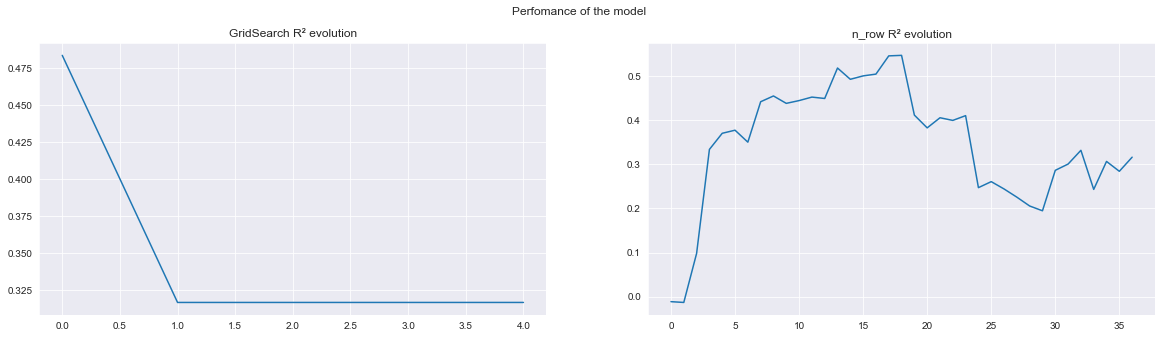

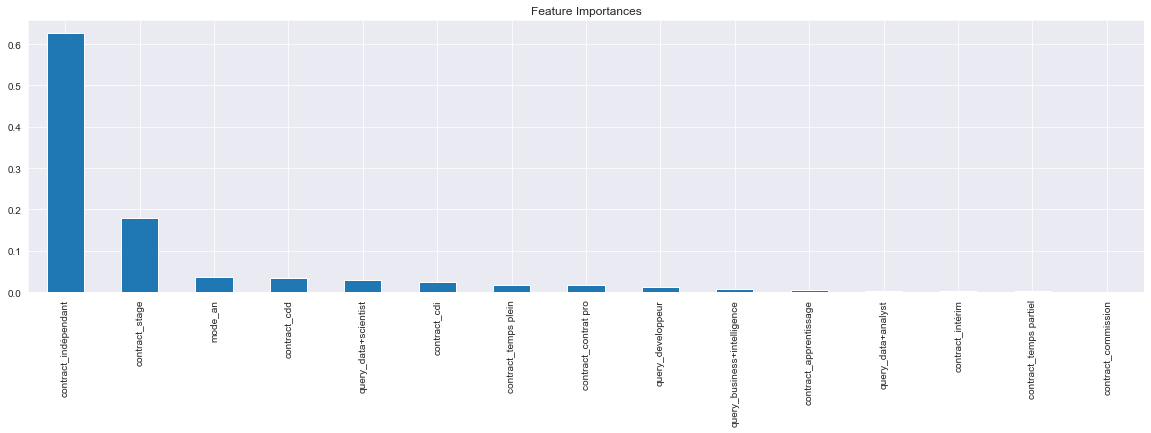

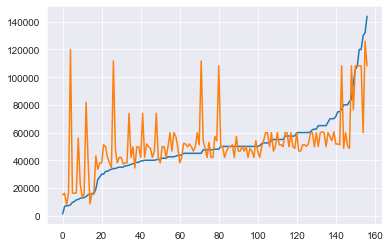

In [23]:
features = list(df.columns[3:14]) + list(df.columns[18:])

plot_searchs(params, np.array(grid_metrics), np.array(n_row_metrics), feature_importances, features)
plot_pred(params, X_train, X_test, y_train, y_test, features)